# Python 3 Environment

You can find instructions for installing PyStan over [here](http://pystan.readthedocs.io/en/latest/installation_beginner.html).

In [24]:
import pystan

print(pystan.__version__)

2.17.1.0


In [25]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from numpy.linalg import inv, cholesky
from numpy.random import uniform
from scipy.special import expit
from scipy.stats import multivariate_normal, bernoulli

In [26]:
# Plot Styling
%matplotlib inline
sns.set()
sns.set_style("darkgrid")
color = 'salmon'
alpha = .7
bins = 100
lw = 2
linestyle = '-'
linecolor = 'r'
linealpha = .8

# Introduction  

Rosiglitazone was authorized to enter the market for the treatment of type 2 diabetes in the United States in 1999 and in the European Union in 2000. New data subsequently emerged about possible cardiovascular risks associated with Rosiglitazone, confirmed by a meta-analysis in Nissen and Wolski (2007), which resulted European countries to suspended and US to partially restrict it. In this casestudy we propose a Bayesian model to help understand the effects of Rosiglitazone. We hope that this model can help regulators interpret clinical trials data and incorporate it in their decision making. 

## When to approve a drug?

Regulators focus on a few key factors when deciding whether a drug is fit to enter the market. In the case of Rosiglitazone, for example, previous work (Phillips et al. 2013). concentrated on 11 of the drug's effects, weighing positive effects against negative effects. Clinical trials data are presented to experts and clinicians to assess the safety of the drug. The clinical analysis of trial data is based on statistical summaries of the data, including averages, standard deviations, and signifiance levels. However, dependencies between the effects are the subject of clinical judgment and are rarely included in the statistical summaries.

We propose a Bayesian method to model clinical trial data. This model uses latent variables to account for the whole joint distribution of the treatment effects, including effects of different types. This model will allow us to simulate the effect of the drug on a new patient. Regulators could use this results to inform their decisions on whether to approve a drug or not. 

## How to model the dependence between discrete and continuous observations?

It is common in clinical trials to collect "yes/no" data. We want to fully model this process of interrelated dependencies, incorporate the dependence between the different measurements for each person, and account for uncertainty. Furthermore, datapoints collected in clinical trials are routinely of mixed type: binary, continuous, counts, etc. The main purpose of this work is to extend the current framework so that it can incorporate interdependencies between different features, both discrete and continuous.

Our data is organized with one subject per row and one effect per column. For example, if our clinical trial dataset records 3 effects per subject, 'Hemoglobin Levels' (continuous), 'Nausea' (yes/no) and 'Dyspepsia' (yes/no) the dataset would look like this:

|Subject ID| Group Type|Hemoglobin Level  | Dyspepsia |Nausea |
|--------- | --------- | -------- | ---------|---------|
|123 | Control    | 3.42  | 1 |0 |
|213 | Treatment  | 4.41  | 1 |0 |
|431 | Control    | 1.12  | 0 |0 |
|224 | Control    | -0.11 | 1 |0 |
|224 | Treatment  | 2.42  | 1 |1 |

To model the effects of a drug we need a generative model for these 3 effects that also allows for dependencies between these effects. It stands to reason that the probability of a subject experiencing Nausea is not independent of the probability of experiencing Dyspepsia. To this end, we adopt a parametric generative model to learn the covariance matrix directly. 

We denote the observed data by $y$ and the parameters of the model by $\theta$. We are then interested in the posterior distribution $\pi(\theta | y)$, with which we can draw samples from the distribution of effects $f(y'|y)$ on future, so far unseen, patients $y'$ conditional on observations $y$ as follows:

$$
f(y'|y) = \int f(y'|y,\theta) \pi(\theta|y) d\theta
$$
In practice we cannot analytically derive the full posterior $\pi(\theta | y)$, but we can get samples from it using _Stan_. Consequently, we can approximate the expectation of any function $h(y')$ on the future data
$$
\mathbb{E} (h (y') | y) = \int \int h(y') f(y'|y,\theta) \pi(\theta|y) d\theta dy' = \int h(y') f(y'|y) dy'
$$
using Monte Carlo.

We assume that each subject is independently and identically distributed within its group. We run inference for each group separately and get two sets of parameters, one for the treatment group and one for the placebo, also known as control group. Using the samples from the predictive distribution of each group we can produce samples for the difference between the two groups. Generally, with these posterior samples we can compute any value of interest currently used to decide whether to approve the drug. As an application, we will later show what such an evaluation function looks like and work through a complete example (see Application section).

# Methodology

Let $Y$ be a $N\times K$ matrix where each column represents an effect and each row refers to an individual subject. This is our observations, our clinical trials dataset. In order to distinguish the treatment from placebo subjects, we will analyse the data for each group $Y^T$ and $Y^{C}$ separately. As the model for $Y^T$ and $Y^{C}$ is identical, we suppress the notation into $Y$ in the remainder of this section for convenience. Recall that the important feature of the data is that each column in $Y$ may be measured on different scales, i.e. binary, count or continuous etc. The main purpose of this work is to extend the current framework so that it can incorporate interdependencies between different features, both discrete and continuous.

We consider the following general latent variable framework. The idea to assign appropriate distributions on each column and apply appropriate transformations on their parameters via user specified link functions $h_{j}(\cdot)$, so that everything is brought on the same scale. For example, let's fix our attention on the $i$-th subject for a moment. Then if the $j$-th effect is measured in the binary scale, the model can be

\begin{equation}
\label{eq:binary}
\begin{cases}
Y_{ij}\; \sim\; \text{Bernoulli}(\eta_j),\;i=1,\dots,N,\;Y_{ij} \text{ independent, for fixed } j\\
h_{j}(\eta_j) \; = \; \mu_j + Z_{ij},\\
\end{cases}
\end{equation}

where the link function can be the logit, probit or any other bijection from $[0, 1]$ to the real line. Similarly, for count data on the $j$-th column we can adopt the following model

\begin{equation}
\label{eq:counts}
\begin{cases}
Y_{ij}\; \sim\; \text{Poisson}(\eta_j),\;i=1,\dots,N,\;Y_{ij} \text{ independent, for fixed } j\\
h_{j}(\eta_j) \; = \; \mu_j + Z_{ij}. 
\end{cases}
\end{equation}

where $h_{j}(\cdot)$ could be the natural logarithm, whereas for continuous data one can simply write 

\begin{equation}
\label{eq:contain}
Y_{ij}\; = \; \mu_j + Z_{ij},\;i=1,\dots,N.\\
\end{equation}

In order to complete the model we need to define the $N\times K$ matrix $Z$. Here we use a K-variate Normal distribution $\mathcal{N}_K(\cdot)$ on each $Z_{i :}$ row, such that


\begin{equation}
\label{eq:Zdist}
Z_{i\cdot} \;\sim\; \mathcal{N}_{K}(0_{K},\Sigma),
\end{equation}

where $\Sigma$ is a $K\times K$ covariance matrix, $O_{K}$ is a row $K$-dimensional vector with zeros and $Z_{i\cdot}$ are independent for all $i$. Of course other options are available, e.g. a multivariate $t$.

In the model above, vector $\mu=(\mu_{1},\dots,\mu_K)$ represents quantities related with the mean of each effect, whereas matrix $\Sigma$ models their covariance. Note that the variance of binary variables is non identifiable (Chib and Greenberg (1998), Talhouk, Doucet, and Murphy (2012)), so we focus on the correlation matrix instead.

# Stan Code

For this case study we use the Bernoulli likelihood for the binary data with a logit link function. The Stan program encoding this model is the following:

In [4]:
with open('../models/modelcode.stan', 'r') as file:
    print(file.read())

data {
 int<lower=0> N;
 int<lower=0> K;
 int<lower=0> Kb;
 int<lower=0> Kc;
 int<lower=0, upper=1> yb[N, Kb];
 vector[Kc] yc[N];
}

transformed data {
  matrix[Kc, Kc] I = diag_matrix(rep_vector(1, Kc));
}

parameters {
  vector[Kb] zb[N];
  cholesky_factor_corr[K] L_R;  // first continuous, then binary
  vector<lower=0>[Kc] sigma;
  vector[K] mu;
}

transformed parameters {
  matrix[N, Kb] z;
  vector[Kc] mu_c = head(mu, Kc);
  vector[Kb] mu_b = tail(mu, Kb);
  {
    matrix[Kc, Kc] L_inv = mdivide_left_tri_low(diag_pre_multiply(sigma, L_R[1:Kc, 1:Kc]), I);
    for (n in 1:N){
      vector[Kc] resid = L_inv * (yc[n] - mu_c);
      z[n,] = transpose(mu_b + tail(L_R * append_row(resid, zb[n]), Kb));
    }
  }
}

model {
  mu ~ normal(0, 10);
  L_R ~ lkj_corr_cholesky(2);
  sigma~cauchy(0, 2.5);
  yc ~ multi_normal_cholesky(mu_c, diag_pre_multiply(sigma, L_R[1:Kc, 1:Kc]));
  for (n in 1:N) zb[n] ~ normal(0, 1);
  for (k in 1:Kb) yb[, k] ~ bernoulli_logit(z[, k]);
}

generated quantities 

In [6]:
with open('../models/modelcode.stan', 'r') as file:
    model_code = file.read()

We will fit the model with synthetic data that we generate as follows: 

In [7]:

def C_to_R(M):
    """
    Send a covariance matrix M to the corresponding
    correlation matrix R
    Inputs
    ============
    - M : covariance matrix
    Output
    ============
    - correlation matrix
    """

    d = np.asarray(M.diagonal())
    d2 = np.diag(d**(-.5))
    R = np.dot(np.dot(d2, M), d2)
    return R


def gen_data(N=400, Kb=1, Kc=2, random_seed=234234999):
    """
    Generate data of dimension [N, Kb+Kc]
    Inputs
    ============
    - N : number of rows/subjects
    - Kb : number of binary effects
    - Kc : number of conitnuous effects
    Output
    ============
    - correlation matrix
    """
    np.random.seed(random_seed)

    N1 = N // 2  # size of Group1
    N2 = N - N1  # size of Group2
    K = Kb + Kc  # total number of effects

    A = np.tril(uniform(-1, 1, size=(K, K)))
    C = np.dot(A, A.T)
    R = C_to_R(C)
    
    # Choose variances
    sigma = uniform(1, 4, size=Kc)
    
    # Construct the covariance matrix
    D = np.diag(np.concatenate((sigma, np.ones(Kb))))  
    Sigma =  D.dot(R).dot(D)
    
    # Means for Group 1
    mu_c = uniform(-10, 10, size=Kc)
    mu_b = uniform(-1, 1, size=Kb)
    mu1 = np.concatenate([mu_c, mu_b], axis=0)

    # Means for Group 2
    mu2 = mu1.copy()
    mu2[:Kc] = mu2[:Kc] + uniform(-5, -3, size=Kc)
    mu2[Kc:] = mu2[Kc:] + uniform(-.5, -2, size=Kb)


    # group1
    z = multivariate_normal.rvs(mean=mu1, cov=Sigma, size=N1)
    y1 = np.empty(z.shape)
    y1[:, Kc:] = bernoulli.rvs(p=expit(z[:, Kc:]))
    y1[:, :Kc] = z[:, :Kc]

    # group2
    z = multivariate_normal.rvs(mean=mu2, cov=Sigma, size=N2)
    y2 = np.empty(z.shape)
    y2[:, :Kc] = z[:, :Kc]
    y2[:, Kc:] = bernoulli.rvs(p=expit(z[:, :Kb]))


    return y1, y2, mu1, mu2, R, sigma, N1, N2, Kb, Kc

It's good practice to save the data and posterior samples of the model fit to it. 
In our case, we will need it again when we demonstrate how to fit the model on the real datasets. For the purposes of this notebook, we will re-use this data in place of the hypothetical control group dataset. We can save the data and the samples as follows:

In [8]:
y_control, y_treat, mu_control, mu_treat, R, sigma, N_control, N_treat, Kb, Kc = gen_data(N=400, Kb=4, Kc=2)

In [9]:
data_control = dict(N=N_control, Kb=Kb, Kc=Kc, K=Kb+Kc, yb=y_control[:, Kc:].astype(int),yc=y_control[:, :Kc])
pickle.dump(data_control, open("data_control.pkl", "wb"))

data_treat = dict(N=N_treat, Kb=Kb, Kc=Kc, K=Kb+Kc, yb=y_treat[:, Kc:].astype(int),yc=y_treat[:, :Kc])
pickle.dump(data_treat, open("data_treat.pkl", "wb"))

We compile the model with the following code.

In [10]:
sm = pystan.StanModel(model_code=model_code, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_389cd056347577840573e8f6df0e7636 NOW.
INFO:pystan:OS: darwin, Python: 3.6.4 | packaged by conda-forge | (default, Dec 23 2017, 16:54:01) 
[GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)], Cython 0.27.3


Compiling /var/folders/x4/9t2lxpnx30q0xbrfyc3q9ghr0000gn/T/tmpql1gt9ka/stanfit4anon_model_389cd056347577840573e8f6df0e7636_1284273565998195262.pyx because it changed.
[1/1] Cythonizing /var/folders/x4/9t2lxpnx30q0xbrfyc3q9ghr0000gn/T/tmpql1gt9ka/stanfit4anon_model_389cd056347577840573e8f6df0e7636_1284273565998195262.pyx
building 'stanfit4anon_model_389cd056347577840573e8f6df0e7636_1284273565998195262' extension
creating /var/folders/x4/9t2lxpnx30q0xbrfyc3q9ghr0000gn/T/tmpql1gt9ka/var
creating /var/folders/x4/9t2lxpnx30q0xbrfyc3q9ghr0000gn/T/tmpql1gt9ka/var/folders
creating /var/folders/x4/9t2lxpnx30q0xbrfyc3q9ghr0000gn/T/tmpql1gt9ka/var/folders/x4
creating /var/folders/x4/9t2lxpnx30q0xbrfyc3q9ghr0000gn/T/tmpql1gt9ka/var/folders/x4/9t2lxpnx30q0xbrfyc3q9ghr0000gn
creating /var/folders/x4/9t2lxpnx30q0xbrfyc3q9ghr0000gn/T/tmpql1gt9ka/var/folders/x4/9t2lxpnx30q0xbrfyc3q9ghr0000gn/T
creating /var/folders/x4/9t2lxpnx30q0xbrfyc3q9ghr0000gn/T/tmpql1gt9ka/var/folders/x4/9t2lxpnx30q0xbrfyc3q9ghr0

We fit the model with the following code

In [11]:
fit = sm.sampling(data=data_control, iter=200, chains=1)

/Users/Konstantin/anaconda2/envs/rosi_py/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


We save the extracted samples to be used later again

In [12]:
post_samples = fit.extract(permuted=True)  # return a dictionary of arrays
pickle.dump(post_samples, open("fit_control.pkl", "wb"))

To avoid waiting we can load the pre-fit result as follows:

In [13]:
post_samples = pickle.load(open("fit_control.pkl", "rb"))

## Model Diagnostics
We see that max `Rhat` values are good, below 1.01. The effective sample size `n_eff` is good and the rest of the diagnostics are clean.
Below we plot histograms of posterior samples for the mean, correlations and variance of the effects against the true values. 

In [14]:
print(pystan.misc.stansummary(fit, pars=['mu', 'R', 'sigma']))

Inference for Stan model: anon_model_389cd056347577840573e8f6df0e7636.
1 chains, each with iter=200; warmup=100; thin=1; 
post-warmup draws per chain=100, total post-warmup draws=100.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]     -7.53    0.02   0.16  -7.84  -7.64  -7.52   -7.4  -7.23     94   1.02
mu[1]     -2.48  6.8e-3   0.07  -2.59  -2.52  -2.48  -2.44  -2.32    100   0.99
mu[2]     -0.55    0.02   0.17  -0.93  -0.66  -0.55  -0.42  -0.23     68   1.04
mu[3]     -0.78    0.02   0.18  -1.06  -0.91  -0.79  -0.65   -0.4    100   0.99
mu[4]     -0.29    0.02   0.16  -0.59  -0.42  -0.29  -0.19   0.02    100   0.99
mu[5]     -0.45    0.02   0.17  -0.76  -0.58  -0.46  -0.34  -0.11     49   0.99
R[0,0]      1.0     0.0    0.0    1.0    1.0    1.0    1.0    1.0    100    nan
R[1,0]     0.18  6.5e-3   0.06   0.06   0.14   0.18   0.22   0.31     83   1.02
R[2,0]     0.22    0.01   0.14  -0.07   0.12   0.24   0.33   0.47    100   0.99
R[3,0]     0.26

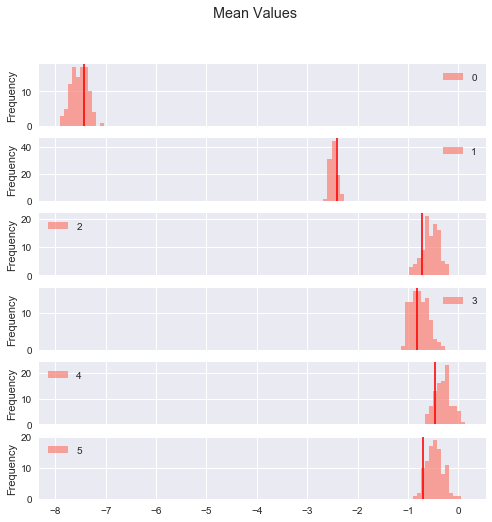

In [15]:
K = Kb + Kc
title = "Mean Values"
true_values = mu_control
df = pd.DataFrame(post_samples['mu'])
df.columns = [str(x) for x in range(K)]

ax = df.plot.hist(subplots=True, title=title, color=color,
                  sharex=True, sharey =False,
                  alpha=alpha, bins=bins,
                  figsize=(8,8));

for i in range(df.shape[1]):
    ax[i].axvline(true_values[i], color=linecolor, alpha=linealpha, linestyle=linestyle, lw=lw);

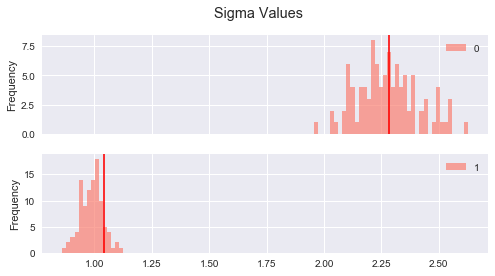

In [16]:
title = "Sigma Values"
true_values = sigma
df = pd.DataFrame(post_samples['sigma'])
df.columns = [str(x) for x in range(Kc)]

ax = df.plot.hist(subplots=True, title=title, color=color,
                  sharex=True, sharey =False,
                  alpha=alpha, bins=bins,
                  figsize=(8,4));

for i in range(df.shape[1]):
    ax[i].axvline(true_values[i], color=linecolor, alpha=linealpha, linestyle=linestyle, lw=lw);

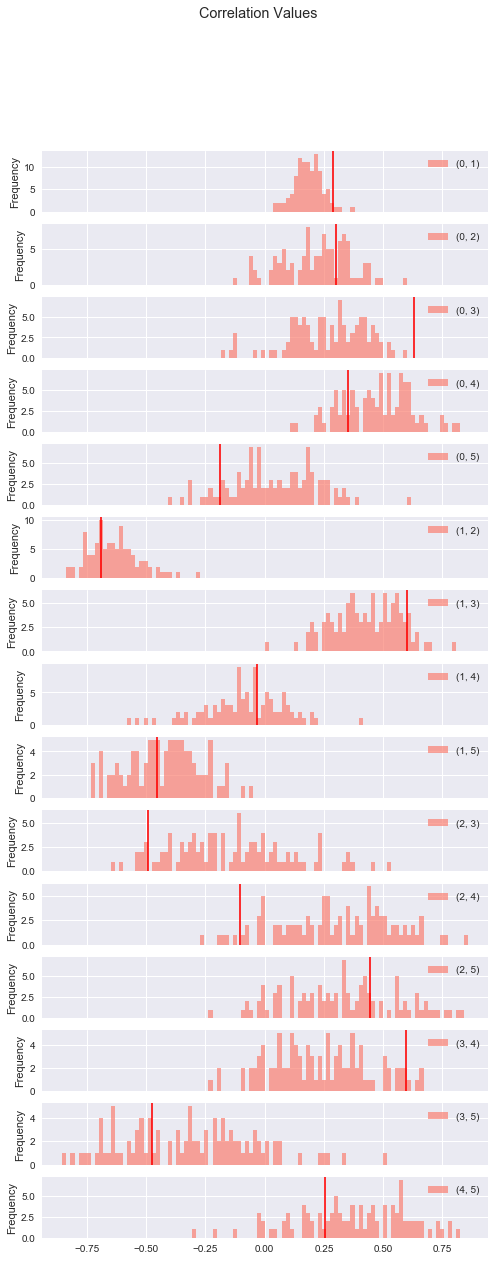

In [17]:
def flatten_corr(a):
    return a[np.triu_indices(a.shape[0], k=1)]


title = "Correlation Values"
true_values= R[np.triu_indices(R.shape[0], k=1)]


Rs = post_samples['R']
num_of_samples = Rs.shape[0]

colnames = np.array([str(x) for x in range(K)])
cnames = zip(colnames[np.triu_indices(colnames.shape[0], k=1)[0]],
             colnames[np.triu_indices(colnames.shape[0], k=1)[1]])

cnames = list(cnames)

M = len(cnames)
fRs = np.empty((num_of_samples, M))
for i in range (num_of_samples):
    fRs[i, :] = flatten_corr(Rs[i, :, :])

df = pd.DataFrame(fRs)
df.columns = cnames


ax = df.plot.hist(subplots=True, title=title, color=color,
                  sharex=True, sharey =False,
                  alpha=alpha, bins=bins,
                  figsize=(8,20));

for i in range(df.shape[1]):
    ax[i].axvline(true_values[i], color=linecolor, alpha=linealpha, linestyle=linestyle, lw=lw);

__Acknowledgments__   
The author would like to thank Jonah Gabry, Bob Carpenter, Andrew Gelman, and Ben Goodrich (who practically wrote the Stan code) for their feedback and help during the process of writing this report.


__License__  

- Code &copy; 2017, Konstantinos Vamvourellis, licensed under BSD-3   
- Text &copy; 2017, Konstantinos Vamvourellis, licensed under CC BY-NC 4.0

# References 

 - Chib, S., and E. Greenberg. 1998. “Analysis of Multivariate Probit Models.” Biometrika 85 (2).

 - Nissen, S. E., and K. Wolski. 2007. “Effect of Rosiglitazone on the Risk of Myocardial Infarction and Death from Cardiovascular Causes.” New England Journal of Medicine 356: 2457–71.

 - Phillips, Lawrence, Billy Amzal, Alex Asiimwe, Edmond Chan, Chen Chen, Diana Hughes, Juhaeri Juhaeri, et al. 2015. “Wave 2 Case Study Report: Rosiglitazone.”

 - Phillips, Lawrence, and others. 2013. “IMI Work Package 5: Report 2:b:ii Benefit - Risk Wave 2 Case Study Report: Rosiglitazone.”

 - Talhouk, A., A. Doucet, and K. Murphy. 2012. “Efficient Bayesian Inference for Multivariate Probit Models with Sparse Inverse Correlation Matrices.” Journal of Computational and Graphical Statistics 21 (3).